<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_1/images/SN_web_lightmode.png" width="300"> 
</center>

# Assignment: Exploratory Data Analysis with ggplot2
Estimated time needed: 60 minutes

# Introduction
Using this R notebook you will perform exploratory data analysis on the Seoul Bike Sharing dataset using Tidyverse and ggplot2.


### Setup libraries and load dataset
We will use local datasets from your project directories.

In [1]:
# Load libraries
suppressPackageStartupMessages({
  library(tidyverse)
  library(lubridate)
  library(ggplot2)
})

# Paths (Windows absolute paths as in the project)
seoul_path <- "C:/Users/Diaa/data.science.with.r/project5-capstone/output/seoul_bike_cleaned.csv"

# Read the cleaned Seoul dataset
seoul_bike_sharing <- readr::read_csv(seoul_path, show_col_types = FALSE)
# Normalize column names to uppercase for consistency with SQL notebook
names(seoul_bike_sharing) <- toupper(names(seoul_bike_sharing))

# Inspect the first few rows
head(seoul_bike_sharing)

DATE,RENTED_BIKE_COUNT,HOUR,TEMPERATURE,HUMIDITY,WIND_SPEED,VISIBILITY,DEW_POINT_TEMPERATURE,SOLAR_RADIATION,RAINFALL,SNOWFALL,SEASONSAUTUMN,SEASONSSPRING,SEASONSSUMMER,SEASONSWINTER,HOLIDAYHOLIDAY,HOLIDAYNO HOLIDAY,FUNCTIONING_DAYNO,FUNCTIONING_DAYYES
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01/12/2017,0.07090602,0.00000000,0.2202797,0.3775510,0.2972973,1,0.2249135,0,0,0,0,0,0,1,0,1,0,1
01/12/2017,0.05683737,0.04347826,0.2150350,0.3877551,0.1081081,1,0.2249135,0,0,0,0,0,0,1,0,1,0,1
01/12/2017,0.04811480,0.08695652,0.2062937,0.3979592,0.1351351,1,0.2231834,0,0,0,0,0,0,1,0,1,0,1
01/12/2017,0.02954418,0.13043478,0.2027972,0.4081633,0.1216216,1,0.2249135,0,0,0,0,0,0,1,0,1,0,1
01/12/2017,0.02138436,0.17391304,0.2062937,0.3673469,0.3108108,1,0.2076125,0,0,0,0,0,0,1,0,1,0,1
01/12/2017,0.02757456,0.21739130,0.1993007,0.3775510,0.2027027,1,0.2058824,0,0,0,0,0,0,1,0,1,0,1


In [2]:
# Reconstruct categorical variables and hour from cleaned dummy columns
seoul_bike_sharing <- seoul_bike_sharing %>%
  mutate(
    SEASONS = case_when(
      SEASONSAUTUMN == 1 ~ "Autumn",
      SEASONSSPRING == 1 ~ "Spring",
      SEASONSSUMMER == 1 ~ "Summer",
      SEASONSWINTER == 1 ~ "Winter",
      TRUE ~ NA_character_
    ),
    HOLIDAY = ifelse(HOLIDAYHOLIDAY == 1, "Holiday", "No Holiday"),
    FUNCTIONING_DAY = ifelse(FUNCTIONING_DAYYES == 1, "Yes", "No"),
    HOUR_INT = pmin(pmax(as.integer(round(HOUR * 23)), 0), 23)
  )

### Task 1 — Recast DATE and HOURS
Recast `DATE` to Date (DD/MM/YYYY) and `HOUR` to an ordered factor.

In [3]:
# Parse DATE as Date (dataset uses DD/MM/YYYY)
seoul_bike_sharing <- seoul_bike_sharing %>%
  mutate(
    DATE = lubridate::dmy(DATE),
    HOUR = factor(HOUR_INT, levels = 0:23, ordered = TRUE)
  )

str(seoul_bike_sharing)

tibble [8,760 × 23] (S3: tbl_df/tbl/data.frame)
 $ DATE                 : Date[1:8760], format: "2017-12-01" "2017-12-01" ...
 $ RENTED_BIKE_COUNT    : num [1:8760] 0.0709 0.0568 0.0481 0.0295 0.0214 ...
 $ HOUR                 : Ord.factor w/ 24 levels "0"<"1"<"2"<"3"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ TEMPERATURE          : num [1:8760] 0.22 0.215 0.206 0.203 0.206 ...
 $ HUMIDITY             : num [1:8760] 0.378 0.388 0.398 0.408 0.367 ...
 $ WIND_SPEED           : num [1:8760] 0.297 0.108 0.135 0.122 0.311 ...
 $ VISIBILITY           : num [1:8760] 1 1 1 1 1 ...
 $ DEW_POINT_TEMPERATURE: num [1:8760] 0.225 0.225 0.223 0.225 0.208 ...
 $ SOLAR_RADIATION      : num [1:8760] 0 0 0 0 0 ...
 $ RAINFALL             : num [1:8760] 0 0 0 0 0 0 0 0 0 0 ...
 $ SNOWFALL             : num [1:8760] 0 0 0 0 0 0 0 0 0 0 ...
 $ SEASONSAUTUMN        : num [1:8760] 0 0 0 0 0 0 0 0 0 0 ...
 $ SEASONSSPRING        : num [1:8760] 0 0 0 0 0 0 0 0 0 0 ...
 $ SEASONSSUMMER        : num [1:8760] 0 0 0 0 0 0 0

### Task 2 — Descriptive statistics
Summarize key variables and check for missing values.

In [4]:
# Summary of numeric columns
seoul_bike_sharing %>%
  select(RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY,
         DEW_POINT_TEMPERATURE, SOLAR_RADIATION, RAINFALL, SNOWFALL) %>%
  summary()

# Missing values by column
colSums(is.na(seoul_bike_sharing))

# Holiday-related records and percentage
holiday_stats <- seoul_bike_sharing %>%
  summarise(
    total_rows = n(),
    holiday_rows = sum(HOLIDAY == "Holiday", na.rm = TRUE),
    holiday_pct = round(100 * holiday_rows / total_rows, 2)
  )
holiday_stats

# Expected records given FUNCTIONING_DAY observations (count of rows marked 'Yes')
functioning_count <- seoul_bike_sharing %>%
  summarise(rows_yes = sum(FUNCTIONING_DAY == "Yes", na.rm = TRUE))
functioning_count

 RENTED_BIKE_COUNT  TEMPERATURE        HUMIDITY        WIND_SPEED    
 Min.   :0.00000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.06162   1st Qu.:0.3724   1st Qu.:0.4286   1st Qu.:0.1216  
 Median :0.15194   Median :0.5507   Median :0.5816   Median :0.2027  
 Mean   :0.20283   Mean   :0.5362   Mean   :0.5941   Mean   :0.2331  
 3rd Qu.:0.29917   3rd Qu.:0.7045   3rd Qu.:0.7551   3rd Qu.:0.3108  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   VISIBILITY     DEW_POINT_TEMPERATURE SOLAR_RADIATION       RAINFALL       
 Min.   :0.0000   Min.   :0.0000        Min.   :0.000000   Min.   :0.000000  
 1st Qu.:0.4627   1st Qu.:0.4481        1st Qu.:0.000000   1st Qu.:0.000000  
 Median :0.8469   Median :0.6176        Median :0.002841   Median :0.000000  
 Mean   :0.7146   Mean   :0.5999        Mean   :0.161679   Mean   :0.004248  
 3rd Qu.:1.0000   3rd Qu.:0.7855        3rd Qu.:0.264205   3rd Qu.:0.000000  
 Max.   :1.0000   Max.   :1.0000        Ma

DATE     RENTED_BIKE_COUNT                  HOUR 
                    0                     0                     0 
          TEMPERATURE              HUMIDITY            WIND_SPEED 
                    0                     0                     0 
           VISIBILITY DEW_POINT_TEMPERATURE       SOLAR_RADIATION 
                    0                     0                     0 
             RAINFALL              SNOWFALL         SEASONSAUTUMN 
                    0                     0                     0 
        SEASONSSPRING         SEASONSSUMMER         SEASONSWINTER 
                    0                     0                     0 
       HOLIDAYHOLIDAY     HOLIDAYNO HOLIDAY     FUNCTIONING_DAYNO 
                    0                     0                     0 
   FUNCTIONING_DAYYES               SEASONS               HOLIDAY 
                    0                     0                     0 
      FUNCTIONING_DAY              HOUR_INT 
                    0                     0

total_rows,holiday_rows,holiday_pct
<int>,<int>,<dbl>
8760,432,4.93


rows_yes
<int>
8465


### Task 3 — Weather by Seasons
Compute average rainfall and snowfall grouped by `SEASONS`.

In [5]:
season_weather <- seoul_bike_sharing %>%
  group_by(SEASONS) %>%
  summarise(
    avg_rainfall = mean(RAINFALL, na.rm = TRUE),
    avg_snowfall = mean(SNOWFALL, na.rm = TRUE),
    avg_bike = mean(RENTED_BIKE_COUNT, na.rm = TRUE)
  ) %>%
  arrange(desc(avg_bike))
season_weather

SEASONS,avg_rainfall,avg_snowfall,avg_bike
<chr>,<dbl>,<dbl>,<dbl>
Summer,0.0072424948,0.00000000,0.29039768
Autumn,0.0035073260,0.00639985,0.24729758
Spring,0.0052251553,0.00000000,0.20816372
Winter,0.0009378307,0.02812500,0.06289848


### Task 4 — Scatter: Rentals over Time
Plot `RENTED_BIKE_COUNT` vs `DATE`.

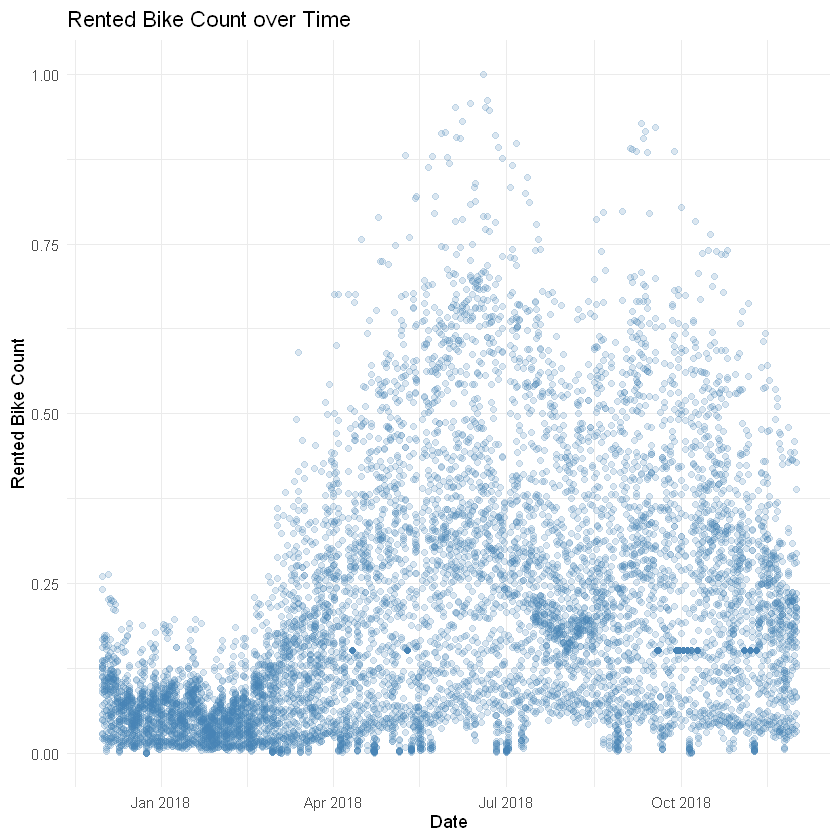

In [6]:
ggplot(seoul_bike_sharing, aes(x = DATE, y = RENTED_BIKE_COUNT)) +
  geom_point(alpha = 0.2, color = "steelblue") +
  labs(title = "Rented Bike Count over Time", x = "Date", y = "Rented Bike Count") +
  theme_minimal()

### Task 5 — Scatter: Rentals over Time colored by Hour
Color by `HOUR` to see hourly patterns.

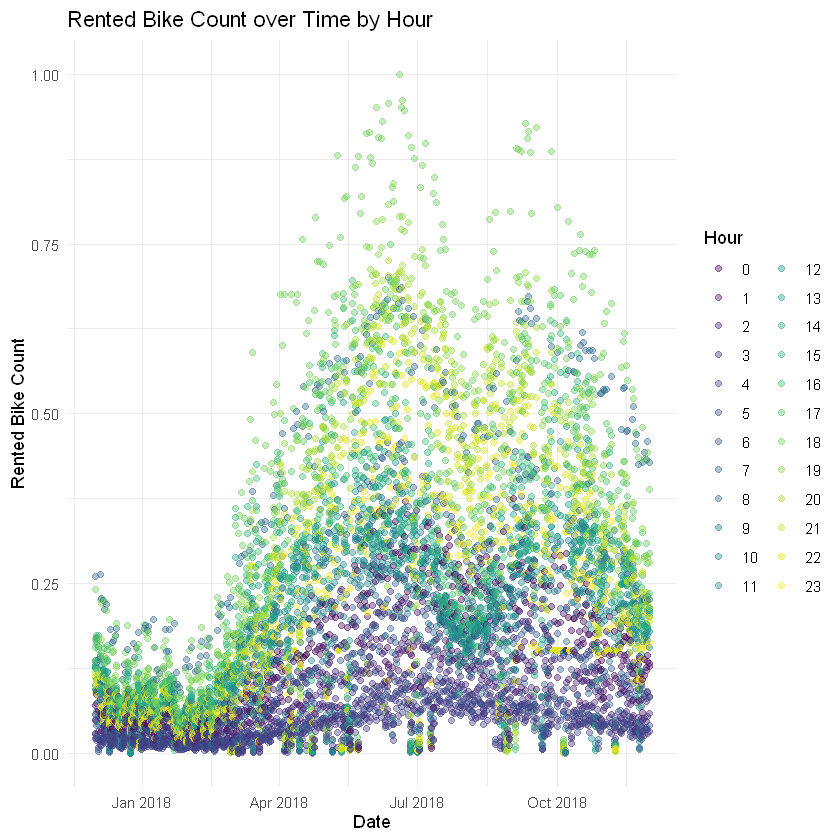

In [7]:
ggplot(seoul_bike_sharing, aes(x = DATE, y = RENTED_BIKE_COUNT, color = HOUR)) +
  geom_point(alpha = 0.4) +
  labs(title = "Rented Bike Count over Time by Hour", x = "Date", y = "Rented Bike Count") +
  theme_minimal() +
  guides(color = guide_legend(title = "Hour"))

### Task 6 — Histogram + Density: Rentals
Visualize the distribution of `RENTED_BIKE_COUNT`.

Warning message:
"The dot-dot notation (`..density..`) was deprecated
in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


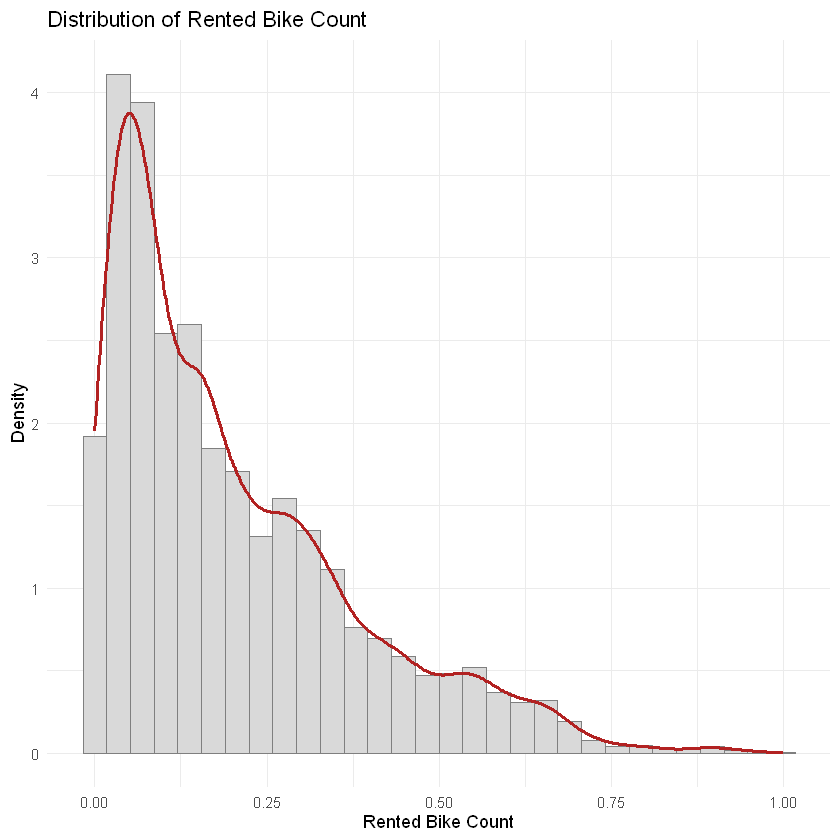

In [8]:
ggplot(seoul_bike_sharing, aes(x = RENTED_BIKE_COUNT)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "gray85", color = "gray50") +
  geom_density(color = "firebrick", linewidth = 1) +
  labs(title = "Distribution of Rented Bike Count", x = "Rented Bike Count", y = "Density") +
  theme_minimal()

### Task 7 — Scatter: Rentals vs Temperature by Season
Explore how temperature relates to rentals across seasons.

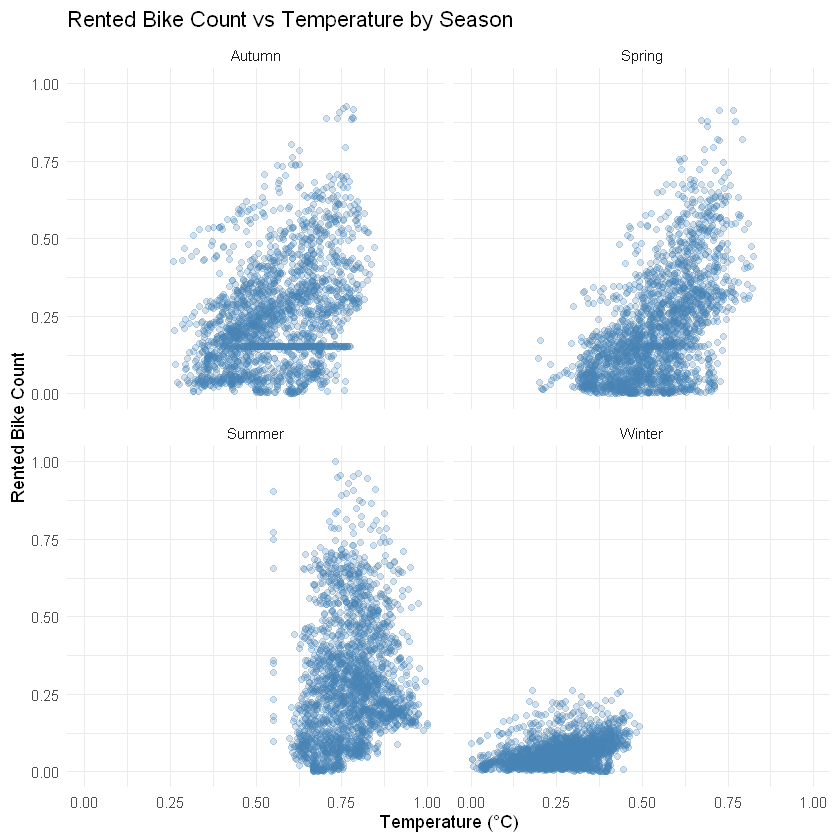

In [9]:
ggplot(seoul_bike_sharing, aes(x = TEMPERATURE, y = RENTED_BIKE_COUNT)) +
  geom_point(alpha = 0.25, color = "steelblue") +
  facet_wrap(~ SEASONS) +
  labs(title = "Rented Bike Count vs Temperature by Season", x = "Temperature (°C)", y = "Rented Bike Count") +
  theme_minimal()

### Task 8 — Boxplot: Rentals by Hour and Season
Compare rental count distributions across hours per season.

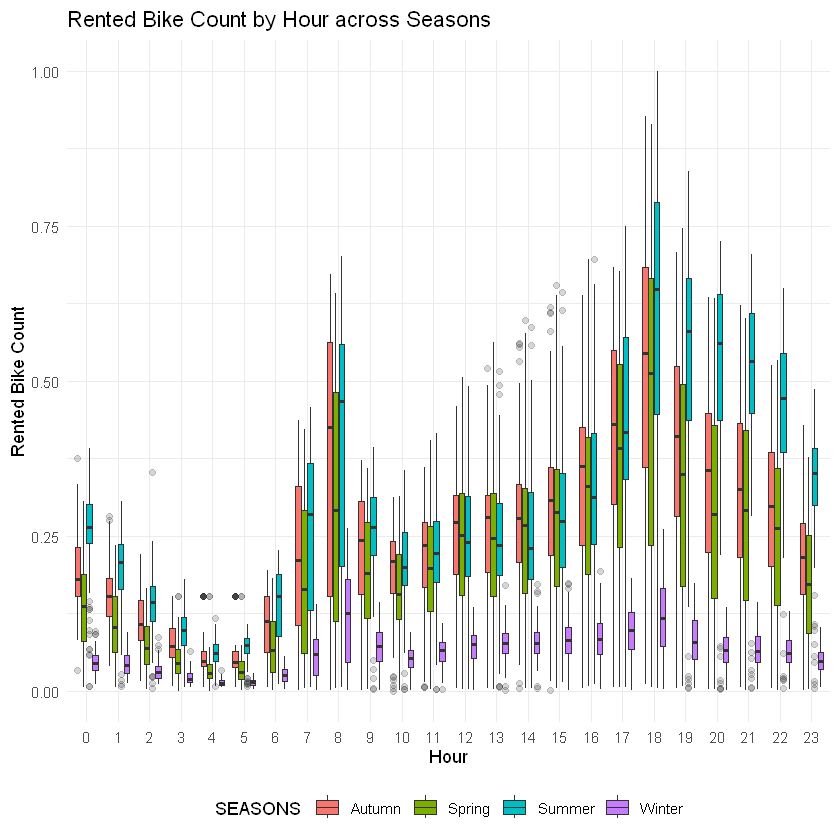

In [10]:
ggplot(seoul_bike_sharing, aes(x = HOUR, y = RENTED_BIKE_COUNT, fill = SEASONS)) +
  geom_boxplot(outlier.alpha = 0.2) +
  labs(title = "Rented Bike Count by Hour across Seasons", x = "Hour", y = "Rented Bike Count") +
  theme_minimal() +
  theme(legend.position = "bottom")

### Task 9 — Daily Rainfall and Snowfall
Aggregate to daily totals and visualize over time.

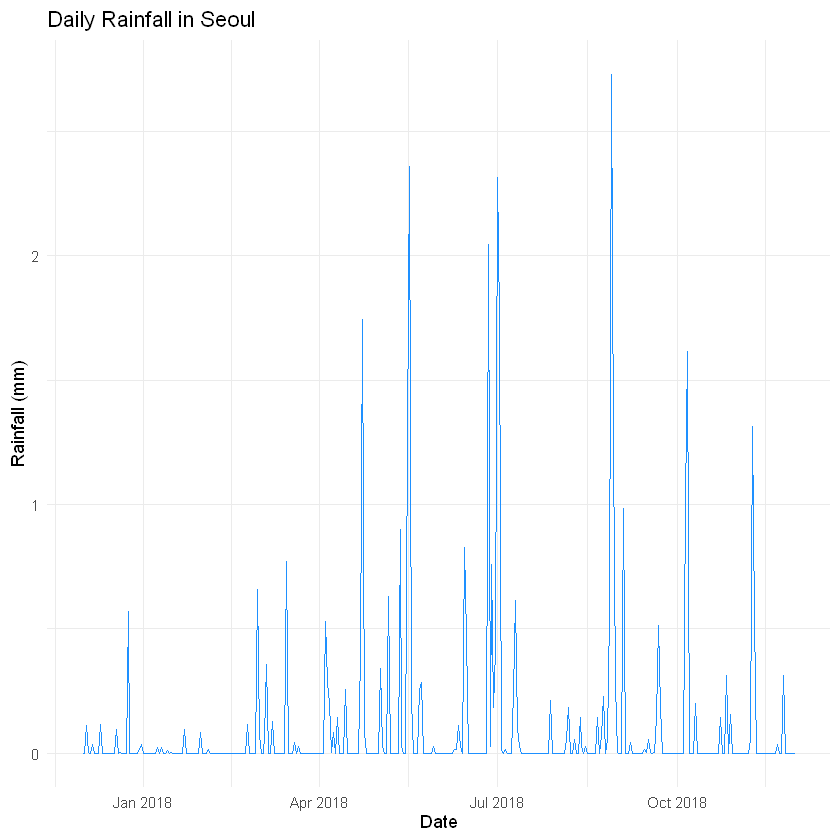

[1] 27

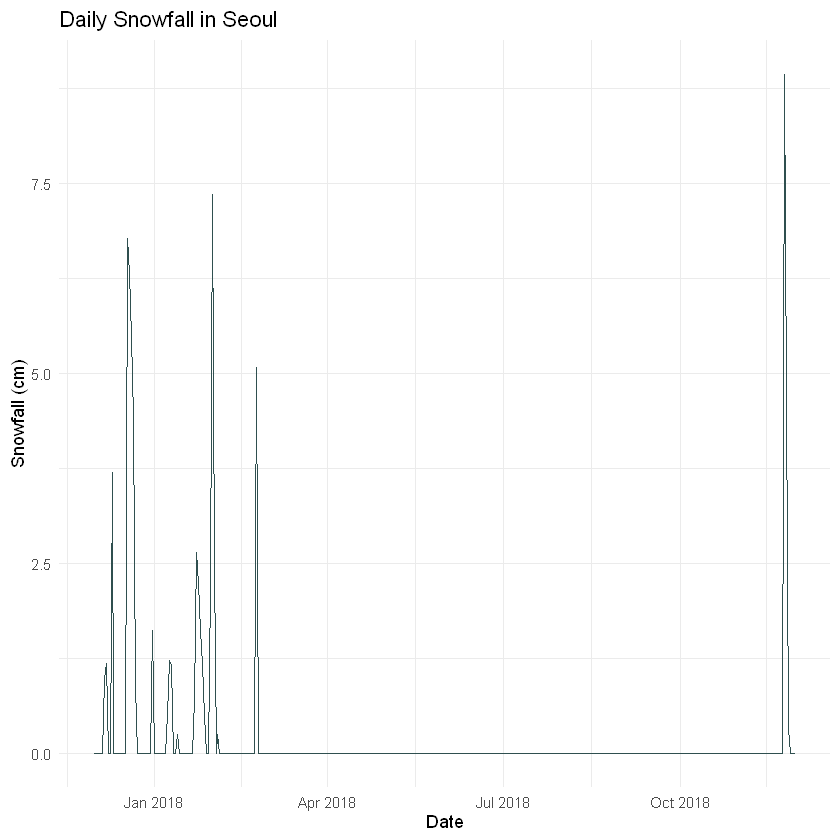

In [11]:
daily <- seoul_bike_sharing %>%
  group_by(DATE) %>%
  summarise(
    daily_rainfall = sum(RAINFALL, na.rm = TRUE),
    daily_snowfall = sum(SNOWFALL, na.rm = TRUE)
  )

# Plot daily rainfall
ggplot(daily, aes(x = DATE, y = daily_rainfall)) +
  geom_line(color = "dodgerblue") +
  labs(title = "Daily Rainfall in Seoul", x = "Date", y = "Rainfall (mm)") +
  theme_minimal()

# Plot daily snowfall
ggplot(daily, aes(x = DATE, y = daily_snowfall)) +
  geom_line(color = "darkslategray") +
  labs(title = "Daily Snowfall in Seoul", x = "Date", y = "Snowfall (cm)") +
  theme_minimal()

# Days with snowfall > 0
days_with_snow <- sum(daily$daily_snowfall > 0, na.rm = TRUE)
days_with_snow

## Author(s)

<h4> Jeff Grossman </h4>
<h4> Lakshmi Holla </h4>

## Other Contributor(s)

<h4>  Malika Singla </h4>

## <h3 align="center"> © IBM Corporation 2022. All rights reserved. <h3/>
